<div style="background-color: #f8ece0; border-radius: 5px; border: 2px solid #61380B; padding: 3px; width: 380px; margin: auto;">
<h1>TP: Détection de contours</h1></div>

Pour lancer un notebook jupyterlab avec l'extension moon, réaliser les instructions suivantes dans un terminal Linux du CREMI
```
cd /net/ens/python/miniconda3/bin
. activate
conda activate moon-juptlab
cd ~
jupyter lab
```

Vérifier l'installation de pillow (PIL)

Les instructions de cette première partie sont à tester pour vérifier le bon fonctionnement des outils. Il est fortement conseillé de prendre un peu de temps pour réaliser les tests et faire éventuellement les réglages nécessaires sur votre distribution Python (Anaconda) pour que l'image s'affiche avec l'instruction *show()* et utiliser un chemin relatif.

In [8]:
from PIL.Image import *

Compléter le code de la cellule suivante pour afficher la taille de l'image *toon.png*. Vous remarquerez que pour afficher l'image dans le notebook on utilise la fonction `display`

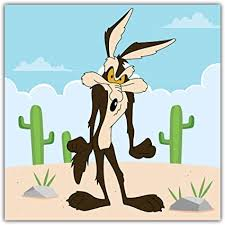

largeur = 225, hauteur = 225


In [20]:
toon = open("/net/cremi/kbalavoine/espaces/travail/Informatique 2/toon.png")
hauteur,largeur=toon.size
display(toon)
print(f"largeur = {largeur}, hauteur = {hauteur}")

**Optionnel** La même dans une fenêtre en dehors du notebook

In [74]:
toon = open("/net/cremi/kbalavoine/espaces/travail/Informatique 2/toon.png")
hauteur,largeur=toon.size
toon.show()
print(f"largeur = {largeur}, hauteur = {hauteur}")

largeur = 225, hauteur = 225


Les parties A et B :  **Niveaux de gris et binarisation** et **Approche Naïve de la détection de contours** sont indépendantes

## Partie A : Niveaux de gris et binarisation

Écrire une fonction `monochrome(img)` qui prend en parmètres une image couleur et renvoie une image de même taille mais en niveau de gris. Pour chaque pixel la fonction calcule l'intensité avec $$lum = \frac{r + g + b}{3}$$ et peint le pixel de la nouvelle image avec $(lum, lum, lum)$.

RGB
L


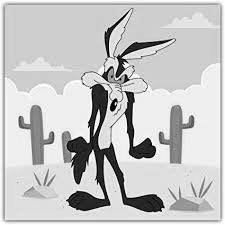

In [125]:
def monochrome(img):
    print(img.mode)
    img1 = new('L',img.size)
    print(img1.mode)
    for i in range(img.size[0]):
        for j in range(img.size[1]):
            r,g,b=img.getpixel((i,j))
            lum=(r+b+g)//3
            img1.putpixel((i,j),lum)
    return img1
toon = open("/net/cremi/kbalavoine/espaces/travail/Informatique 2/toon.png")
monochrome(toon)

Tester la fonction `monochrome`  dans la cellule ci-dessous avec l'image *toon.png*

161


Vous pouvez remarquez qu'avec cette transformation nous perdons certains détails comme le fait que les cactus contiennent des nuances de couleurs. Cette différence est dûe au fait que les couleurs avec des longueurs d'onde différentes sont perçues différemment par l'oeil humain. Nous allons affecter aux différentes couleurs différents poids. L'oeil humain est sensible au vert, ainsi le poids le plus élevé est utilisé pour le vert $0.7152$, le moins sensible est le bleu, avec un poids de $0.0722$, et le rouge utilise un poids de $0.2126$.

$$lum = 0.2126*r+0.7152*g+0.0722*b$$

Modifier la fonction `monochrome` en conséquence.

Observer la différence en testant votre nouvelle fonction monochrome dans la cellule ci-dessous.

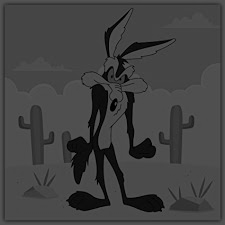

In [114]:
def monochrome1(img):
    img.show()
    for i in range(img.size[0]):
        for j in range(img.size[1]):
            r,g,b=img.getpixel((i,j))
            lum=int((0.2126*r+0.7152*g+0.0722*b)/3)
            img.putpixel((i,j),(lum,lum,lum))
    return img
toon = open("/net/cremi/kbalavoine/espaces/travail/Informatique 2/toon.png")
monochrome1(toon)

La **binarisation** est la transformation d'une image en niveaux de gris en image binaire (noir et blanc). Pour cela nous allons utiliser une technique très simple appelée seuillage. Le seuillage d'image est une méthode permettant de rassembler entre eux les pixels d'une région à partir d'un critère précis. Dans notre exemple à partir d'une image en niveaux de gris, le seuillage d'image peut être utilisé pour créer une image comportant uniquement deux couleurs, noir et blanc, d'où la notion d'image binaire. Ces deux couleurs sont définies par les niveaux d'intensité de gris 0 pour le noir et 255 pour le blanc. Le seuillage d'image permet donc de remplacer un à un les pixels d'une image en comparant avec une valeur seuil, les pixels de la nouvelle image prennent la valeur 0 en dessous du seuil et la valeur 255 sinon.

Écrire une fonction `seuillage(img)` qui prend en parmètre une image et renvoie une image dont les pixels d'intensité inférieure ou égale à 127 sont noirs et ceux d'intensité strictement supérieure à 127 sont blancs

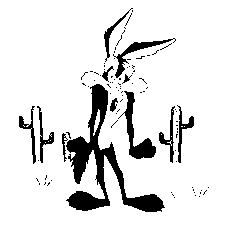

In [112]:
def seuillage(img,seuil=127):
    for i in range(img.size[0]):
        for j in range(img.size[1]):
            r,g,b=img.getpixel((i,j))
            if r<seuil:
                r=0
            else:
                r=255
            img.putpixel((i,j),(r,r,r))
    return img

toon = open("/net/cremi/kbalavoine/espaces/travail/Informatique 2/toon.png")
seuillage(toon,127)

Tester la fonction `seuillage`  sur l'image monochrome de *toon.png* dans la cellule ci-dessous.

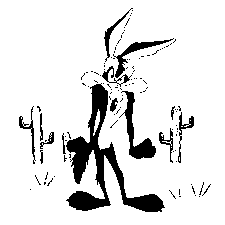

In [116]:
#your code
toon = open("/net/cremi/kbalavoine/espaces/travail/Informatique 2/toon.png")
seuillage(monochrome(toon))

## Partie B : Approche naïve de la détection de contours

Commençons avec une image binaire comme ci-dessous : contoursV.png. Elle présente une seule discontinuité de l'intensité. Les bords noirs ne sont pas présents sur le fichier image, ils ont été ajoutés uniquement pour délimiter les bords de l'image sur le fond blanc de la page. Les contours cherchés se réduisent dans ce cas à une ligne verticale, frontière entre le noir et le blanc. Notre objectif est d'obtenir une nouvelle image dans laquelle seule cette frontière sera conservée.

![contoursV](images/contoursVAvecCadre.png)

Écrire une fonction `contoursV(img)` qui prend en paramètre une image et renvoie une nouvelle image de même taille avec pour chaque pixel la valeur de la différence des intensités entre le pixel $(i,j)$ et le pixel $(i-1, j)$.

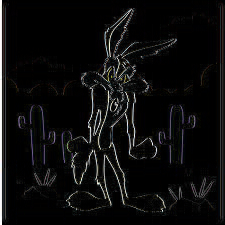

In [119]:
def contoursV(img):
    for i in range(img.size[0]-1,1,-1):
        for j in range(img.size[1]):
            r1,g1,b1=img.getpixel((i,j))
            r2,g2,b2=img.getpixel((i-1,j))
            img.putpixel((i,j),(abs(r1-r2),abs(g1-g2),abs(b1-b2)))
    return img



toon = open("/net/cremi/kbalavoine/espaces/travail/Informatique 2/toon.png")
contoursV(toon)

Appliquer la fonction `contoursV` à l'image *contoursV.png* puis *formes.png*. **Attention ces images sont déjà monochromes.**

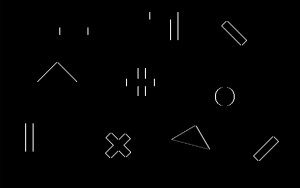

In [123]:
def contoursV(img):
    for i in range(img.size[0]-1,1,-1):
        for j in range(img.size[1]):
            r1=img.getpixel((i,j))
            r2=img.getpixel((i-1,j))
            img.putpixel((i,j),(abs(r1-r2)))
    return img



contours = open("/net/cremi/kbalavoine/espaces/travail/Informatique 2/contoursV.png")
formes = open("/net/cremi/kbalavoine/espaces/travail/Informatique 2/formes.png")
contoursV(formes)

In [ ]:
#your code

Que remarquez-vous avec l'image *formes.png* ? Vous repondrez à cette question dans cette même cellule en faisant un double clic dessus

**Votre réponse :** 

Écrire une fonction `contoursH(img)` qui prend en paramètre une image et renvoie une nouvelle image de même taille avec pour chaque pixel la valeur de la différence des intensités entre le pixel $(i,j)$ et le pixel $(i, j-1)$.

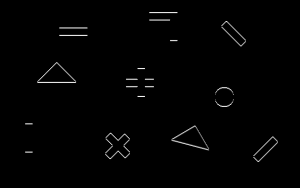

In [127]:
def contoursH(img):
    imgH=new('L',img.size)
    for i in range(img.size[0]):
        for j in range(img.size[1]-1,1,-1):
            r1=img.getpixel((i,j))
            r2=img.getpixel((i,j-1))
            imgH.putpixel((i,j),(abs(r1-r2)))
    return imgH



contours = open("/net/cremi/kbalavoine/espaces/travail/Informatique 2/contoursV.png")
formes = open("/net/cremi/kbalavoine/espaces/travail/Informatique 2/formes.png")
contoursH(formes)

Appliquer la fonction `contoursH` à l'image *contoursV.png* puis *formes.png*.

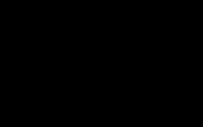

In [128]:
def contoursH(img):
    imgH=new('L',img.size)
    for i in range(img.size[0]):
        for j in range(img.size[1]-1,1,-1):
            r1=img.getpixel((i,j))
            r2=img.getpixel((i,j-1))
            imgH.putpixel((i,j),(abs(r1-r2)))
    return imgH



contours = open("/net/cremi/kbalavoine/espaces/travail/Informatique 2/contoursV.png")
formes = open("/net/cremi/kbalavoine/espaces/travail/Informatique 2/formes.png")
contoursH(contours)

In [ ]:
#your code

Que remarquez-vous pour l'image *formes.png* ? Vous repondrez à cette question dans cette même cellule en faisant un double clic dessus

**Votre réponse :** 

À l'aide des fonctions `contoursV` et `contoursH` écrire une fonction `contoursNaifImage(img)` qui prend en paramètre une image source et renvoie uniquement les contours détectés de l'image source. L'intensité de chaque pixel de l'image finale ($I_F$) sera calculée à l'aide de la relation suivante : 

$$I_F(x,y) = \sqrt{I_{CV}^2(x,y) + I_{CH}^2(x,y)}$$
avec 
* $I_{CV}$ : image obtenue avec la fonction `contoursV`
* $I_{CH}$ : image obtenue avec la fonction `contoursH`

In [ ]:
from math import sqrt
def contoursNaifImage(img):
    If=new('L')
    
contours = open("/net/cremi/kbalavoine/espaces/travail/Informatique 2/contoursV.png")
formes = open("/net/cremi/kbalavoine/espaces/travail/Informatique 2/formes.png")

Appliquer la fonction `contoursNaifImage` à *formes.png* 

In [ ]:
#your code

## Partie C : Détection de contours et seuillage

Essayons maintenant notre détection de contours sur l'image monochrome de notre toon. On observe que tous les contours ne sont pas forcément bien marqués. L'herbe des rochers n'est complète et les nuages sont à peine visibles.

![contours_monochrome](images/contours_monochrome.png)

La binarisation de notre image permet d'améliorer la détection des contours. Dans la cellule ci-dessous utiliser à nouveau notre détecteur de contours sur l'image ainsi binariser de *toon.png*.

In [ ]:
#your code

Dans la cellule ci-dessous, afficher les contours de l'image *musique.png* 

![musique](images/musique.png)

In [ ]:
#your code

Que remarquez-vous pour les contours de ces deux images ? Vous repondrez à cette question dans cette même cellule en faisant un double clic dessus

**Votre réponse :** 

Pour palier à cet inconvénient nous allons modifier notre fonction de seuillage. Pour décider de la couleur noire ou blanche des pixels nous avions choisi un seuil à 127 qui semblait convenir à notre image de départ. Mais il n'y a aucune raison valable que cette valeur s'applique à toutes images. Écrire une fonction `seuilGlobale(img)` qui prend en paramètres une image et qui renvoie la valeur seuil comme la moyenne des intensités sur tous les pixels. 

In [ ]:
def seuilGlobale(img):
    #your code
    pass

Modifier la fonction `seuillage` de la cellule C17 pour qu'elle puisse utiliser la valeur retournée par la fonction `seuilGlobale`

Écrire une suite d'instructions permettant de tester vos modifications sur les images *musique.png* et "toon.png"

In [ ]:
#your code

In [ ]:
#your code

In [ ]:
# FIN